In [1]:
import pandas as pd
import random
from time import sleep
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import nltk
import os
from sklearn import datasets
import pickle
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, fbeta_score
from sklearn.model_selection import learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize
import re
from unidecode import unidecode

import matplotlib.style as style
%matplotlib inline
plt.style.use('ggplot')

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open('data/cleaned_df.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [3]:
df.head()

,song_owner,song_title,song_element,verse,artist
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino


In [4]:
model_df = df.copy()

model_df = model_df[model_df['artist'] == 'Childish Gambino']

In [5]:
model_df['verse_words'] = model_df['verse'].copy()
model_df['verse_words'] = model_df['verse_words'].str.lower()
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.replace(',',''))
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.split(' '))

In [6]:
model_df.head()

,song_owner,song_title,song_element,verse,artist,verse_words
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino,"[we, just, wanna, party, party, just, for, you..."
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino,"[this, is, america, don't, catch, you, slippin..."
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino,"[this, is, america, (skrrt, skrrt, woo), don't..."
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino,"[ooh-ooh-ooh-ooh-ooh, tell, somebody, you, go,..."
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino,"[this, is, america, (woo, ayy), don't, catch, ..."


In [7]:
from nltk.tokenize import word_tokenize
model_df['tokenize_verse'] = model_df['verse'].copy()
model_df['tokenize_verse'] = model_df['tokenize_verse'].str.lower()
model_df['tokenize_verse'] = model_df['tokenize_verse'].apply(lambda x: word_tokenize(x))

In [8]:
model_df['verse'] = model_df['verse'].str.lower()
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace("'",''))
model_df['verse'] = model_df['verse'].apply(lambda x: "".join([c if c.isalnum() else " " for c in x ]))
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace('  ',' '))

In [9]:
stopwords = ["yeah", "uh", "huh", "aw", "oh", "la", "ayy",
            "na", "ha", "ay", "skrrt",
            "em", "bla", "woo", "wu", "ya", "wala", "woop", "wrarrr", "ooh",
            "ba", "duh", "du", "1", "2", "3", "4" ,"5" ,"6", "7", "8", "9", "0"]

for index, row in model_df.iterrows():
    querywords = row['verse'].split()

    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    row['verse'] = ' '.join(resultwords)

model_df.verse[:5]

0    we just wanna party party just for you we just...
1    this is america dont catch you slippin now don...
2    this is america dont catch you slippin now loo...
3    tell somebody you go tell somebody grandma tol...
4    this is america dont catch you slippin now don...
Name: verse, dtype: object

In [10]:
verses = list(model_df.verse.values)

In [11]:
verses[:10]

['we just wanna party party just for you we just want the money money just for you i know you wanna party party just for free girl you got me dancin girl you got me dancin dance and shake the frame we just wanna party party just for you we just want the money money just for you you i know you wanna party party just for free girl you got me dancin girl you got me dancin dance and shake the frame',
 'this is america dont catch you slippin now dont catch you slippin now look what im whippin now this is america dont catch you slippin now dont catch you slippin now look what im whippin now',
 'this is america dont catch you slippin now look how im livin now police be trippin now this is america guns in my area word my area i got the strap i gotta carry ima go into this ugh this is guerilla ima go get the bag or ima get the pad im so cold like im so dope like we gon blow like straight up',
 'tell somebody you go tell somebody grandma told me get your money black man get your black man get yo

In [12]:
all_verses_all_rappers = ','.join(verses)

all_verses_all_rappers[:100]

'we just wanna party party just for you we just want the money money just for you i know you wanna pa'

In [13]:
file = all_verses_all_rappers

In [14]:
# Read in text and change unicode characters to ASCII
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file_len = len(file)
print(f'file_len = {file_len}')

file_len = 360644


In [15]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

t that some shit really though sealy posturepedic ho when she in my bed but she aint havent even seen a video now shoot that whos that roll up on niggas like fruit snacks you better walk big gambino but you aint got money motherfucker thats too bad thats like countin fat stacks out in harlem thats like fucking kat stacks with no condom stupid everybody out here needs to cool it rap stepfather no mo


In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        output = self.encoder(input.view(1, -1))
        output, hidden = self.gru(output.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.randn(self.n_layers, 1, self.hidden_size))

In [17]:
def char2tensor(string):
    tensor = torch.zeros(len(string)).long()
    for char in range(len(string)):
        if string[char] in all_characters:
            tensor[char] = all_characters.index(string[char])
        else:
            tensor[char] = 94 #predict space if character unknown
        
    return Variable(tensor)

# Let's see it in action.
print(char2tensor('Metis0123abczABC'))

tensor([48, 14, 29, 18, 28,  0,  1,  2,  3, 10, 11, 12, 35, 36, 37, 38])


In [18]:
def random_training_set():
    chunk = random_chunk()
    inp = char2tensor(chunk[:-1])
    target = char2tensor(chunk[1:])
    return inp, target

In [19]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    
    hidden = model.init_hidden()
    prime_input = char2tensor(prime_str)
    predicted = prime_str
    
    # use priming string to build up hidden state
    
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char2tensor(predicted_char)
        
    return predicted

In [20]:
# helper function
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [21]:
# The actual training part
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for char in range(chunk_len):
        output, hidden = model(inp[char], hidden)
        loss += criterion(output, target[char].unsqueeze(0))

    loss.backward()
    model_optimizer.step()

    return loss.data.item() / chunk_len

In [22]:
# parameters
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 2
learning_rate = 0.001

# model declaration
model = RNN(n_characters, hidden_size, n_characters, n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'A ', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 11s (100 10%) 2.2554]
A cisri fom nog do thand lllathe real,eld te note klnu kunge mecarcke goven cint hont cume ind ing do  

 19s (200 20%) 2.0086]
A galdine pind a suse a fly by i for sumngita nise ill i watn the sine i these i gom mother boyry ber  

 28s (300 30%) 1.9370]
A cond anstaneas and dand shit funger m she shit man a like you word a she and s wrem ive bool they my 

 35s (400 40%) 1.8989]
A the get it fanning on thing i dont feree dew its and firjer veroney be of i wanna done what if m whi 

 42s (500 50%) 1.6615]
A a gon whis to dont now not love now be constone to we are the night but me couse its it love wan i m 

 50s (600 60%) 1.5223]
A bright on to get to the play the you wappe bright that going shit ever we for the amarchis aly cath  

 56s (700 70%) 1.2832]
A it the want a ppoy though this my niggas tose giver greep this fly money you know shit me doing get  

 2s (800 80%) 1.5022]
A i girl you aint all spitch like im sway hath white with ill its ood at she just 

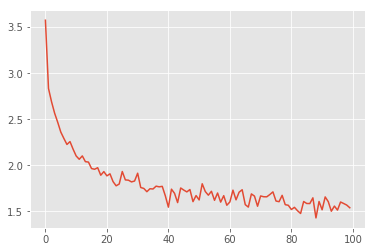

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [24]:
with open('models/childish_rnn_generator.pkl', 'wb') as picklefile:
    pickle.dump(model, picklefile)

In [25]:
# Evaluate model from this notebook
print(evaluate(model, 'To be or not to be: ', predict_len=200, temperature=0.5))

To be or not to be: you days like never fly in and the be and i am black bank and and these calling me it feel get i for the face so mind she talk the same i got a hand these get i man brother be and it me the brome im s


In [26]:
# Evaluate model from this notebook
print(evaluate(model, 'I miss you girl come back ', predict_len=200, temperature=0.5))

I miss you girl come back im im nigga be girl your face and in my mind man with a man but you that know i aint but i got a feel get me be man you got the back like a fake my say i do wont sick a rand i talk she time and im jus


In [27]:
# Evaluate model from this notebook
print(evaluate(model, "Started from the bottom", predict_len=200, temperature=0.4))

Started from the bottom and it so mind baby man get i m and i aint me i know money girl you can be saying hold you said the feeling my money be got the same the fuck me and i m days but i dont say i dont get the music i so 


In [28]:
# Evaluate model from this notebook
print(evaluate(model, "I'm the realest rapper alive", predict_len=200, temperature=0.4))

I'm the realest rapper alive i am and i dont be at for and a lotter the burn and i am baby im sick my than man i dont get i dont that i say i got that get i money so got me man but i man got i am be baby man man and i dont can t


In [29]:
# Evaluate model from this notebook
print(evaluate(model, "Smoke a lot of weed", predict_len=200, temperature=0.4))

Smoke a lot of weed the baby got a nigga man be make it can i am cause in my fly gotta not so a fly got a man i m got that we got the speend i dont move i gotta be but i wanna get i say man want that man the money baby 


In [30]:
# Evaluate model from this notebook
print(evaluate(model, "Baby come", predict_len=200, temperature=0.4))

Baby come it money hold my same i dont me and i can be game me im and my black have you and wanna be and that i say my for you and i dont a fuck you got a rapper get it and in my fly what i say i m so in and m
